In [2]:
import matplotlib.pyplot as plt

import torch

from torchvision.datasets import CelebA
from torchvision import transforms

from torch.utils.data import DataLoader

from glow import GLOW
import normflows as nf

import torchvision as tv
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(),
    transforms.Resize(96),
    transforms.CenterCrop(96),
])

flow = GLOW(3, 32, (3, 96, 96), 40, 256)
flow.model.load_state_dict(torch.load('models/glow/glow_celeba_3_32_256_50000.pt', map_location=torch.device('cpu')))

c:\Users\luana\AppData\Local\pypoetry\Cache\virtualenvs\lime-sohamHBj-py3.11\Lib\site-packages\torch\_tensor.py:791: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:1994.)
  LU, pivots, infos = torch._lu_with_info(
C:\Users\luana\AppData\Local\Temp\ipykernel_10424\4055504626.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will exe

<All keys matched successfully>

c:\Users\luana\AppData\Local\pypoetry\Cache\virtualenvs\lime-sohamHBj-py3.11\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return tor

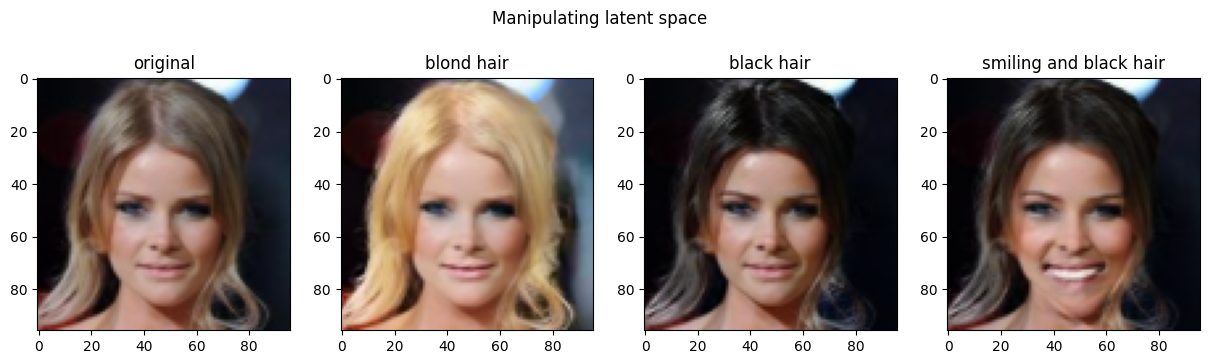

In [6]:
import pickle
import copy
from PIL import Image

image = Image.open('data/000010.jpg')
instance = transform(image)

latent_manipulators = pickle.load(open('latent_manipulators.pkl', 'rb'))

sample = instance.unsqueeze(0)
latent1 = flow.to_latent(sample)
latent2 = flow.to_latent(sample)
latent3 = flow.to_latent(sample)
latent1[0] = latent1[0] + 1.5 * latent_manipulators[9]
latent2[0] = latent2[0] + 1.5 * latent_manipulators[8]
latent3[0] = latent3[0] + 1.5 * latent_manipulators[31]
latent3[0] = latent3[0] + 1.5 * latent_manipulators[8]
recon1 = flow.to_image(latent1)
recon2 = flow.to_image(latent2)
recon3 = flow.to_image(latent3)

plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)
plt.imshow(sample[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.title('original')

plt.subplot(1, 4, 2)
plt.imshow(recon1[0][0].detach().cpu().numpy().transpose(1, 2, 0))
plt.title('blond hair')

plt.subplot(1, 4, 3)
plt.imshow(recon2[0][0].detach().cpu().numpy().transpose(1, 2, 0))
plt.title('black hair')

plt.subplot(1, 4, 4)
plt.imshow(recon3[0][0].detach().cpu().numpy().transpose(1, 2, 0))
plt.title('smiling and black hair')

plt.suptitle('Manipulating latent space')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009374379..255.0].


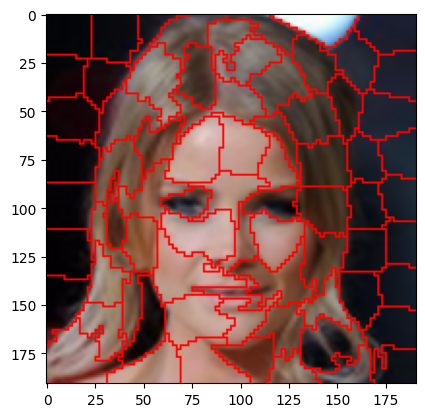

In [134]:
from abc import abstractmethod
from lime import DiscreteSampler
from typing import List, Tuple

from joblib import Parallel, delayed

from skimage.segmentation import slic, mark_boundaries

class FlowSampler(DiscreteSampler):

    def __init__(self, segments: np.ndarray, flow: GLOW, manipulators: dict, alpha: float = 0.3, scale: float = 0.4, loc: float = 0, n_jobs: int = 1):
        super().__init__(segments, n_jobs, alpha)
        self.flow = flow
        self.manipulators = manipulators
        self.scale = scale
        self.loc = loc

    def sample(self, instance: np.ndarray, num_samples: int) -> List[Tuple[np.ndarray, np.ndarray]]:
        def generate_sample_parallel(instance):
            return self.generate_sample(instance)

        samples = Parallel(n_jobs=self.n_jobs)(
            delayed(generate_sample_parallel)(instance)
            for _ in range(num_samples)
        )
        return samples

    def generate_sample(self, instance: np.ndarray) -> np.ndarray:
        sample = np.copy(instance).transpose(1, 2, 0)
        latent = self.flow.to_latent(torch.tensor(instance).unsqueeze(0))
        for i, manipulator in self.manipulators.items():
            latent[0] = latent[0] + np.random.normal(loc=self.loc, scale=self.scale) * manipulator
        recon = self.flow.to_image(latent)[0][0].detach().cpu().numpy().transpose(1, 2, 0)

        # get the difference between the original and the reconstructed image and mean it for each segment
        diff = np.abs(sample - recon)  
        
        # calculate the mean diff for each segment
        sample = np.zeros_like(sample)

        for i in range(len(self.segments)):
            sample[self.segments == i] = np.mean(diff[self.segments == i])

        return recon, np.sum(sample, axis=-1)
    
segments = slic(np.array(instance).transpose(1, 2, 0), n_segments=80, compactness=15)
plt.imshow(mark_boundaries(np.array(instance).transpose(1, 2, 0), segments, mode='subpixel', color=[255, 0, 0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0029904544..1.0195951].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012450853..255.0].


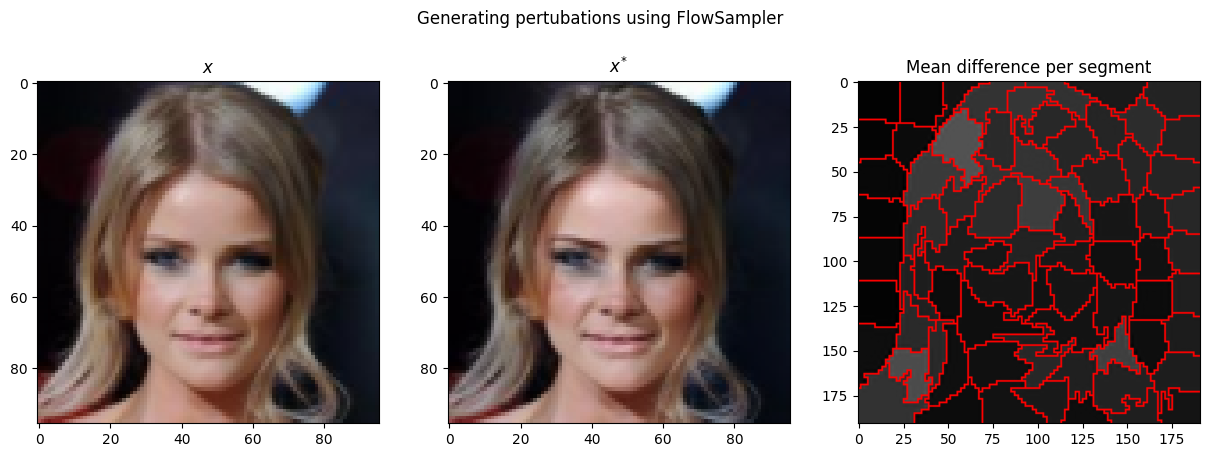

In [159]:
sampler = FlowSampler(segments, flow, latent_manipulators, scale=0.3, loc=0, n_jobs=1, alpha=0.5)
samples = sampler.sample(np.array(instance), 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.array(instance).transpose(1, 2, 0))
plt.title('$x$')

plt.subplot(1, 3, 2)
plt.imshow(samples[0][0])
plt.title('$x^{*}$')

plt.subplot(1, 3, 3)
plt.imshow(mark_boundaries(samples[0][1], segments, mode='subpixel', color=[255, 0, 0]), cmap='gray')
plt.title('Mean difference per segment')

plt.suptitle('Generating pertubations using FlowSampler')

plt.show()